Prediction on Fine-tuned Models

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import keras
import cv2
import glob
import numpy as np
from keras.models import *
from keras.layers import *
import scipy.io as sio
from scipy.ndimage import rotate
import matplotlib.pyplot as plt


def predicted_output(model,X_dev, height=68,width=68,n_ops=2):
        batch_len=X_dev.shape[0]
        # print("X dev shape",  X_dev.shape)
        pr = model.predict(X_dev)
        # print(np.array(pr).shape)
        # print(np.array(pr).shape)
        pr = np.argmax(pr,axis=-1)
        pred = np.zeros((pr.shape[0],pr.shape[1],height,width),dtype = int)
        for i in range(n_ops-1):
                pred[:,:,:,:] = ((pr==i+1)*255).astype(int)
        #sio.savemat(dir_path+'pr_dev.mat', {'y_pred':pred,'name_dev':name})
        # print("dffdf", pred.shape)
        return pred


def compute_iou(truth, prediction):
    """
    Compute the Intersection over Union (IoU) between two binary images.
    
    Parameters:
    truth (numpy array): The first binary image.
    prediction (numpy array): The second binary image.
    
    Returns:
    float: The IoU score.
    """
    
    # Calculate intersection and union
    intersection = np.logical_and(truth, prediction).sum()
    union = np.logical_or(truth, prediction).sum()
    
    if union == 0:
        return 0.0
    
    # Compute IoU
    iou = intersection / union
    return iou


def compute_dice(truth, prediction):
    
    intersection = np.logical_and(truth, prediction).sum()
    area = truth.sum() + prediction.sum()
    
    if area == 0:
        return 0.0
    
    # Compute Dice
    dice = 2 * intersection / area
    return dice


def plot_scores(subjects, pca, iou, dice, contour_number):
        plt.scatter(subjects, pca, label='PCA')
        plt.scatter(subjects, iou, label='IoU')
        plt.scatter(subjects, dice, label='Dice')
        
        # ymin = np.min([min(pca), min(iou), min(dice)])
        
        plt.ylim([0, 1])
        plt.legend()
        plt.xlabel('Video')
        plt.ylabel('Scores')
        plt.title(f'Scores Comparison of Contour {contour_number}')
        plt.savefig(f'{pred_folder}/contour{contour_number}_scores.png')
        plt.show()


test_videos_path = '74subjects_data/Videos Scaled to 68/'
test_videos = ['FS2sub5', 'MS2sub6']

lists = [
        ['F1M1','F12M12','F123M123','F1234M1234'],
        ['F1M1','F12M12','F123M123','F1235M1235'],
        ['F1M1','F12M12','F124M124','F1245M1245'],
        ['F1M1','F13M13','F134M134','F1345M1345'],
        ['F2M2','F23M23','F234M234','F2345M2345']
        ]

base_models = lists[0]

videos_for_training = ['2','4','8']
frames_for_tuning = [1,5,10,15]
# [1,2,3,4,5,10,15,20,25,30,35,40,45]

runs = 10
# runs = 1


height = 68
width = 68
n_ops = 2


for m in base_models:
    for v_num in videos_for_training:
        for num_frames_to_select in frames_for_tuning:  # Number of random frames to select from each video
             for run in range(runs):
        

                save_path=(f'Finetuned_Weights/Unseen_Recording/{m}/{v_num}videos/{num_frames_to_select}frames/run{run+1}/')
                mat_save = save_path + 'predicted_masks/'
                print(save_path)
                segnet_model = load_model(save_path + 'model_finetuned.weights')
                # segnet_model.summary()

                if not os.path.exists(mat_save):
                                        print("creating test directory : "+mat_save)
                                        os.makedirs(mat_save)

                vid = test_videos
                for vl in range(len(vid)):
                        # print("hello")
                        vidcap = cv2.VideoCapture(test_videos_path + vid[vl] + '.mp4')
                        a=[]
                        names_test = []
                        success = True
                        while success:
                                success,image = vidcap.read()
                                a.append(image)
                        a = np.array(a)
                        b = np.zeros((a.shape[0]-1,68,68,3))
                        for i in range(a.shape[0]-1):
                                # names_test.append(subs[sub]+'_'+vid[vl]+str(i).zfill(3))
                                b[i,:,:,:] = a[i]
                        b=b.astype('float64')
                        b=b/255
                        # if not os.path.exists(mat_save):
                        #         print("creating test directory : "+mat_save)
                        #         os.makedirs(mat_save)
                        # else:
                        #         print("image directory already exists")
                        #b_test_rot=np.array(b_test_rot)
                        #names_test_rot = np.array(names_test_rot)
                        b=np.array(b)
                        # names_test = names_test[0:len(names_test)]
                        # names_test = np.array(names_test)
                        #print(np.array(b).shape)
                        #print(np.array(names_test).shape)
                        preds = predicted_output(segnet_model,b,height,width,n_ops=2)
                        # print(preds.shape)
                        """for i in range(preds.shape[0]):
                        for j in range(preds.shape[1]):
                                for k in range(preds.shape[2]):
                                for l in range(preds.shape[3]):
                                        if preds[i][j][k][l] != 0:
                                        print("haha")"""
                        sio.savemat(mat_save+vid[vl]+'.mat', {'pred':preds})



                pred_folder = mat_save
                gt_folder = '74subjects_data/Matmasks_68/'  # Folder should contain the mat files directly without any subfolders
                # gt_subfolder = [f'F{s_n}masks',f'M{s_n}masks']
                # mat_files = [f'F{s_n}_003',f'F{s_n}_004',f'F{s_n}_005',f'M{s_n}_003',f'M{s_n}_004',f'M{s_n}_005']

                clean_pca, clean_iou, clean_dice = np.zeros((3,2)), np.zeros((3,2)), np.zeros((3,2))
                
                for i in range(len(test_videos)):
                        
                        mat1 = sio.loadmat(pred_folder + test_videos[i] + '.mat')
                        
                        mat2 = sio.loadmat(gt_folder + f'{test_videos[i]}_mask_gt.mat')
                        # print(mat2.keys())
                        # print(mat2['masks'].shape)
                        
                        y = mat1['pred']  # contour no., frame no., height, width
                        x = mat2['masks_struct'][0]  # frame no., contour no.
                        
                        y = (y/y.max()).astype(int)
                        frames = x.shape[0]
                                
                        frame_accuracy = np.zeros((9,frames), dtype=float)
                        
                        for contour in range(3):
                                for frame in range(frames):
                                        frame_accuracy[contour, frame] = np.sum(x[frame][contour] == y[contour][frame]) / (68*68)
                                        frame_accuracy[contour+3,frame] = compute_iou(x[frame][contour], y[contour][frame])
                                        frame_accuracy[contour+6,frame] = compute_dice(x[frame][contour], y[contour][frame])
                                
                                clean_pca[contour][i] = np.mean(frame_accuracy[contour])
                                clean_iou[contour][i] = np.mean(frame_accuracy[contour+3])
                                clean_dice[contour][i] = np.mean(frame_accuracy[contour+6])


                

                # Plotting the scores for each contour
                for i in range(3):
                        plot_scores(['Subject1', 'Subject2'], clean_pca[i], clean_iou[i], clean_dice[i], i + 1)
                
                print('PCA: \ncontour1 ->', clean_pca[0].mean(),
                        '\ncontour2 ->', clean_pca[1].mean(),
                        '\ncontour3 ->', clean_pca[2].mean(),
                '\nIoU: \ncontour1 ->', clean_iou[0].mean(),
                        '\ncontour2 ->', clean_iou[1].mean(),
                        '\ncontour3 ->', clean_iou[2].mean(),
                '\nDice: \ncontour1 ->', clean_dice[0].mean(),
                        '\ncontour2 ->', clean_dice[1].mean(),
                        '\ncontour3 ->', clean_dice[2].mean())

                # Define the file name and combine it with the folder path
                file_path = os.path.join(pred_folder, 'countours_scores.txt')

                # Open the file in write mode and create it in the specified folder
                with open(file_path, 'w') as file:
                # Prepare the content to be written
                        content = (f'PCA: \ncontour1 -> {clean_pca[0].mean()}'
                                f'\ncontour2 -> {clean_pca[1].mean()}'
                                f'\ncontour3 -> {clean_pca[2].mean()}'
                                f'\nIoU: \ncontour1 -> {clean_iou[0].mean()}'
                                f'\ncontour2 -> {clean_iou[1].mean()}'
                                f'\ncontour3 -> {clean_iou[2].mean()}'
                                f'\nDice: \ncontour1 -> {clean_dice[0].mean()}'
                                f'\ncontour2 -> {clean_dice[1].mean()}'
                                f'\ncontour3 -> {clean_dice[2].mean()}')
                        
                        # Write the content to the file
                        file.write(content)


Prediction on Pre-trained Models without Fine-tuning

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import keras
import cv2
import glob
import numpy as np
from keras.models import *
from keras.layers import *
import scipy.io as sio
from scipy.ndimage import rotate
import matplotlib.pyplot as plt


def predicted_output(model,X_dev, height=68,width=68,n_ops=2):
        batch_len=X_dev.shape[0]
        # print("X dev shape",  X_dev.shape)
        pr = model.predict(X_dev)
        # print(np.array(pr).shape)
        # print(np.array(pr).shape)
        pr = np.argmax(pr,axis=-1)
        pred = np.zeros((pr.shape[0],pr.shape[1],height,width),dtype = int)
        for i in range(n_ops-1):
                pred[:,:,:,:] = ((pr==i+1)*255).astype(int)
        #sio.savemat(dir_path+'pr_dev.mat', {'y_pred':pred,'name_dev':name})
        # print("dffdf", pred.shape)
        return pred


def compute_iou(truth, prediction):
    """
    Compute the Intersection over Union (IoU) between two binary images.
    
    Parameters:
    truth (numpy array): The first binary image.
    prediction (numpy array): The second binary image.
    
    Returns:
    float: The IoU score.
    """
    
    # Calculate intersection and union
    intersection = np.logical_and(truth, prediction).sum()
    union = np.logical_or(truth, prediction).sum()
    
    if union == 0:
        return 0.0
    
    # Compute IoU
    iou = intersection / union
    return iou


def compute_dice(truth, prediction):
    
    intersection = np.logical_and(truth, prediction).sum()
    area = truth.sum() + prediction.sum()
    
    if area == 0:
        return 0.0
    
    # Compute Dice
    dice = 2 * intersection / area
    return dice


def plot_scores(subjects, pca, iou, dice, contour_number):
        plt.scatter(subjects, pca, label='PCA')
        plt.scatter(subjects, iou, label='IoU')
        plt.scatter(subjects, dice, label='Dice')
        
        # ymin = np.min([min(pca), min(iou), min(dice)])
        
        plt.ylim([0, 1])
        plt.legend()
        plt.xlabel('Video')
        plt.ylabel('Scores')
        plt.title(f'Scores Comparison of Contour {contour_number}')
        plt.savefig(f'{pred_folder}/contour{contour_number}_scores.png')
        plt.show()


        
test_videos_path = '74subjects_data/Videos Scaled to 68/'
test_videos = ['FS2sub5', 'MS2sub6']

lists = [
        ['F1M1','F12M12','F123M123','F1234M1234'],
        ['F1M1','F12M12','F123M123','F1235M1235'],
        ['F1M1','F12M12','F124M124','F1245M1245'],
        ['F1M1','F13M13','F134M134','F1345M1345'],
        ['F2M2','F23M23','F234M234','F2345M2345']
        ]

base_models = lists[0]

videos_for_training = ['2','4','8']
frames_for_tuning = [0]

height = 68
width = 68
n_ops = 2


for m in base_models:
    for v_num in videos_for_training:
        for num_frames_to_select in frames_for_tuning:  # Number of random frames to select from each video
        
                # if m == 'F1M1' and v_num == '8' and num_frames_to_select == 45:
                #         continue
                
                save_path=(f'Finetuned_Weights/Unseen_Recording/{m}/{v_num}videos/{num_frames_to_select}frames/')
                mat_save = save_path + 'predicted_masks/'
                segnet_model = load_model(f'Pretrained_Models/{m}/{v_num} videos/weights/model_best.weights')
                # segnet_model.summary()
                print(save_path)
                if not os.path.exists(mat_save):
                        print("creating test directory : "+mat_save)
                        os.makedirs(mat_save)
                        
                vid = test_videos
                for vl in range(len(vid)):
                                # print("hello")
                                vidcap = cv2.VideoCapture(test_videos_path + vid[vl] + '.mp4')
                                a=[]
                                names_test = []
                                success = True
                                while success:
                                        success,image = vidcap.read()
                                        a.append(image)
                                a = np.array(a)
                                b = np.zeros((a.shape[0]-1,68,68,3))
                                for i in range(a.shape[0]-1):
                                        # names_test.append(subs[sub]+'_'+vid[vl]+str(i).zfill(3))
                                        b[i,:,:,:] = a[i]
                                b=b.astype('float64')
                                b=b/255
                                b=np.array(b)
                                # names_test = names_test[0:len(names_test)]
                                # names_test = np.array(names_test)
                                #print(np.array(b).shape)
                                #print(np.array(names_test).shape)
                                preds = predicted_output(segnet_model,b,height,width,n_ops=2)
                                # print(preds.shape)
                                                
                                sio.savemat(mat_save+vid[vl]+'.mat', {'pred':preds})
        


                pred_folder = mat_save
                gt_folder = '74subjects_data/Matmasks_68/'  # Folder should contain the mat files directly without any subfolders
             
                clean_pca, clean_iou, clean_dice = np.zeros((3,2)), np.zeros((3,2)), np.zeros((3,2))
                
                for i in range(len(test_videos)):
                        
                        mat1 = sio.loadmat(pred_folder + test_videos[i] + '.mat')
                        
                        mat2 = sio.loadmat(gt_folder + f'{test_videos[i]}_mask_gt.mat')
                        # print(mat2.keys())
                        # print(mat2['masks'].shape)
                        
                        y = mat1['pred']  # contour no., frame no., height, width
                        x = mat2['masks_struct'][0]  # frame no., contour no.
                        
                        y = (y/y.max()).astype(int)
                        frames = x.shape[0]
                                
                        frame_accuracy = np.zeros((9,frames), dtype=float)
                        
                        for contour in range(3):
                                for frame in range(frames):
                                        frame_accuracy[contour, frame] = np.sum(x[frame][contour] == y[contour][frame]) / (68*68)
                                        frame_accuracy[contour+3,frame] = compute_iou(x[frame][contour], y[contour][frame])
                                        frame_accuracy[contour+6,frame] = compute_dice(x[frame][contour], y[contour][frame])
                                
                                clean_pca[contour][i] = np.mean(frame_accuracy[contour])
                                clean_iou[contour][i] = np.mean(frame_accuracy[contour+3])
                                clean_dice[contour][i] = np.mean(frame_accuracy[contour+6])


                

                # Plotting the scores for each contour
                for i in range(3):
                        plot_scores(['Subject1', 'Subject2'], clean_pca[i], clean_iou[i], clean_dice[i], i + 1)
                
                print('PCA: \ncontour1 ->', clean_pca[0].mean(),
                        '\ncontour2 ->', clean_pca[1].mean(),
                        '\ncontour3 ->', clean_pca[2].mean(),
                '\nIoU: \ncontour1 ->', clean_iou[0].mean(),
                        '\ncontour2 ->', clean_iou[1].mean(),
                        '\ncontour3 ->', clean_iou[2].mean(),
                '\nDice: \ncontour1 ->', clean_dice[0].mean(),
                        '\ncontour2 ->', clean_dice[1].mean(),
                        '\ncontour3 ->', clean_dice[2].mean())

                # Define the file name and combine it with the folder path
                file_path = os.path.join(pred_folder, 'countours_scores.txt')

                # Open the file in write mode and create it in the specified folder
                with open(file_path, 'w') as file:
                # Prepare the content to be written
                        content = (f'PCA: \ncontour1 -> {clean_pca[0].mean()}'
                                f'\ncontour2 -> {clean_pca[1].mean()}'
                                f'\ncontour3 -> {clean_pca[2].mean()}'
                                f'\nIoU: \ncontour1 -> {clean_iou[0].mean()}'
                                f'\ncontour2 -> {clean_iou[1].mean()}'
                                f'\ncontour3 -> {clean_iou[2].mean()}'
                                f'\nDice: \ncontour1 -> {clean_dice[0].mean()}'
                                f'\ncontour2 -> {clean_dice[1].mean()}'
                                f'\ncontour3 -> {clean_dice[2].mean()}')
                        
                        # Write the content to the file
                        file.write(content)


Prediction on Matched Condition

Pretrained_Models/Seen_Recording/1 videos_random/
creating test directory : Pretrained_Models/Seen_Recording/1 videos_random/predicted_masks/


/tmp/ipykernel_1108095/1308354500.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(a)


3/3 [==============================] - 0s 127ms/step


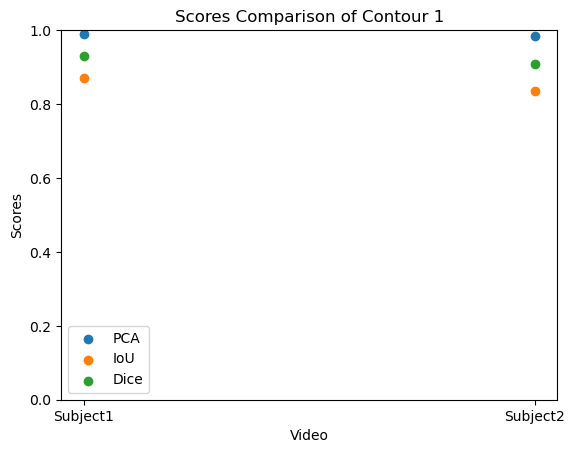

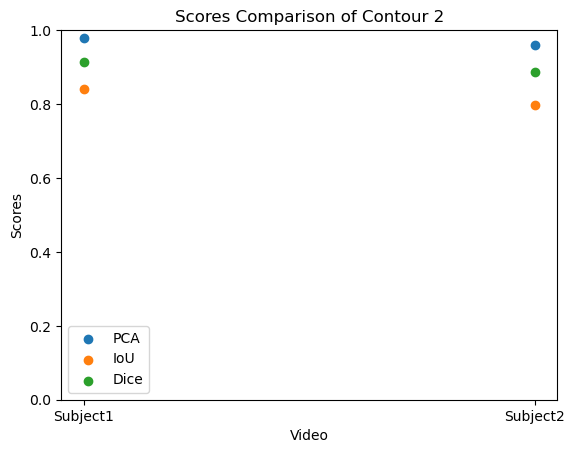

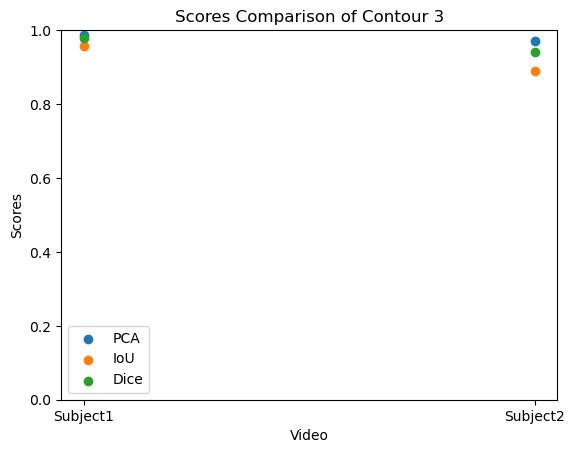

PCA: 
contour1 -> 0.9863299859585777 
contour2 -> 0.9684804548417831 
contour3 -> 0.9777687929391706 
IoU: 
contour1 -> 0.8535427895183967 
contour2 -> 0.8191649374745503 
contour3 -> 0.9235671433828452 
Dice: 
contour1 -> 0.920220976592968 
contour2 -> 0.9001243368622474 
contour3 -> 0.9599055032720589


In [21]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import keras
import cv2
import glob
import numpy as np
from keras.models import *
from keras.layers import *
import scipy.io as sio
from scipy.ndimage import rotate
import matplotlib.pyplot as plt


def predicted_output(model,X_dev, height=68,width=68,n_ops=2):
        batch_len=X_dev.shape[0]
        # print("X dev shape",  X_dev.shape)
        pr = model.predict(X_dev)
        # print(np.array(pr).shape)
        # print(np.array(pr).shape)
        pr = np.argmax(pr,axis=-1)
        pred = np.zeros((pr.shape[0],pr.shape[1],height,width),dtype = int)
        for i in range(n_ops-1):
                pred[:,:,:,:] = ((pr==i+1)*255).astype(int)
        #sio.savemat(dir_path+'pr_dev.mat', {'y_pred':pred,'name_dev':name})
        # print("dffdf", pred.shape)
        return pred


def compute_iou(truth, prediction):
    """
    Compute the Intersection over Union (IoU) between two binary images.
    
    Parameters:
    truth (numpy array): The first binary image.
    prediction (numpy array): The second binary image.
    
    Returns:
    float: The IoU score.
    """
    
    # Calculate intersection and union
    intersection = np.logical_and(truth, prediction).sum()
    union = np.logical_or(truth, prediction).sum()
    
    if union == 0:
        return 0.0
    
    # Compute IoU
    iou = intersection / union
    return iou


def compute_dice(truth, prediction):
    
    intersection = np.logical_and(truth, prediction).sum()
    area = truth.sum() + prediction.sum()
    
    if area == 0:
        return 0.0
    
    # Compute Dice
    dice = 2 * intersection / area
    return dice


def plot_scores(subjects, pca, iou, dice, contour_number):
        plt.scatter(subjects, pca, label='PCA')
        plt.scatter(subjects, iou, label='IoU')
        plt.scatter(subjects, dice, label='Dice')
        
        # ymin = np.min([min(pca), min(iou), min(dice)])
        
        plt.ylim([0, 1])
        plt.legend()
        plt.xlabel('Video')
        plt.ylabel('Scores')
        plt.title(f'Scores Comparison of Contour {contour_number}')
        plt.savefig(f'{pred_folder}/contour{contour_number}_scores.png')
        plt.show()


        
test_videos_path = '/home/wtc14/Masoud/LOW RESOURCE Segmentation/74subjects_data/Videos Scaled to 68/'
test_videos = ['FS2sub5', 'MS2sub6']

height = 68
width = 68
n_ops = 2



save_path=(f'/home/wtc14/Masoud/LOW RESOURCE Segmentation/Pretrained_Models/Seen_Recording/1 videos/')
mat_save = save_path + 'predicted_masks/'
segnet_model = load_model(f'{save_path}weights/model_best.weights')
# segnet_model.summary()
print(save_path)
if not os.path.exists(mat_save):
        print("creating test directory : "+mat_save)
        os.makedirs(mat_save)
        
vid = test_videos
for vl in range(len(vid)):
                # print("hello")
                vidcap = cv2.VideoCapture(test_videos_path + vid[vl] + '.mp4')
                a=[]
                names_test = []
                success = True
                while success:
                        success,image = vidcap.read()
                        a.append(image)
                a = np.array(a)
                b = np.zeros((a.shape[0]-1,68,68,3))
                for i in range(a.shape[0]-1):
                        # names_test.append(subs[sub]+'_'+vid[vl]+str(i).zfill(3))
                        b[i,:,:,:] = a[i]
                b=b.astype('float64')
                b=b/255
                b=np.array(b)
                # names_test = names_test[0:len(names_test)]
                # names_test = np.array(names_test)
                #print(np.array(b).shape)
                #print(np.array(names_test).shape)
                preds = predicted_output(segnet_model,b,height,width,n_ops=2)
                # print(preds.shape)
                                
                sio.savemat(mat_save+vid[vl]+'.mat', {'pred':preds})



pred_folder = mat_save
gt_folder = '/home/wtc14/Masoud/LOW RESOURCE Segmentation/74subjects_data/Matmasks_68/'  # Folder should contain the mat files directly without any subfolders

clean_pca, clean_iou, clean_dice = np.zeros((3,2)), np.zeros((3,2)), np.zeros((3,2))

for i in range(len(test_videos)):
        
        mat1 = sio.loadmat(pred_folder + test_videos[i] + '.mat')
        
        mat2 = sio.loadmat(gt_folder + f'{test_videos[i]}_mask_gt.mat')
        # print(mat2.keys())
        # print(mat2['masks'].shape)
        
        y = mat1['pred']  # contour no., frame no., height, width
        x = mat2['masks_struct'][0]  # frame no., contour no.
        
        y = (y/y.max()).astype(int)
        frames = x.shape[0]
                
        frame_accuracy = np.zeros((9,frames), dtype=float)
        
        for contour in range(3):
                for frame in range(frames):
                        frame_accuracy[contour, frame] = np.sum(x[frame][contour] == y[contour][frame]) / (68*68)
                        frame_accuracy[contour+3,frame] = compute_iou(x[frame][contour], y[contour][frame])
                        frame_accuracy[contour+6,frame] = compute_dice(x[frame][contour], y[contour][frame])
                
                clean_pca[contour][i] = np.mean(frame_accuracy[contour])
                clean_iou[contour][i] = np.mean(frame_accuracy[contour+3])
                clean_dice[contour][i] = np.mean(frame_accuracy[contour+6])




# Plotting the scores for each contour
for i in range(3):
        plot_scores(['Subject1', 'Subject2'], clean_pca[i], clean_iou[i], clean_dice[i], i + 1)

print('PCA: \ncontour1 ->', clean_pca[0].mean(),
        '\ncontour2 ->', clean_pca[1].mean(),
        '\ncontour3 ->', clean_pca[2].mean(),
'\nIoU: \ncontour1 ->', clean_iou[0].mean(),
        '\ncontour2 ->', clean_iou[1].mean(),
        '\ncontour3 ->', clean_iou[2].mean(),
'\nDice: \ncontour1 ->', clean_dice[0].mean(),
        '\ncontour2 ->', clean_dice[1].mean(),
        '\ncontour3 ->', clean_dice[2].mean())

# Define the file name and combine it with the folder path
file_path = os.path.join(pred_folder, 'countours_scores.txt')

# Open the file in write mode and create it in the specified folder
with open(file_path, 'w') as file:
# Prepare the content to be written
        content = (f'PCA: \ncontour1 -> {clean_pca[0].mean()}'
                f'\ncontour2 -> {clean_pca[1].mean()}'
                f'\ncontour3 -> {clean_pca[2].mean()}'
                f'\nIoU: \ncontour1 -> {clean_iou[0].mean()}'
                f'\ncontour2 -> {clean_iou[1].mean()}'
                f'\ncontour3 -> {clean_iou[2].mean()}'
                f'\nDice: \ncontour1 -> {clean_dice[0].mean()}'
                f'\ncontour2 -> {clean_dice[1].mean()}'
                f'\ncontour3 -> {clean_dice[2].mean()}')
        
        # Write the content to the file
        file.write(content)
